<a href="https://colab.research.google.com/github/cm-st-project/flutter-image-classification-tensorflow-lite/blob/main/Image_Classification_example_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Dataset
Source: https://github.com/ultralytics/flickr_scraper

In [ ]:
! git clone https://github.com/ultralytics/flickr_scraper
! pip install -U -r /content/flickr_scraper/requirements.txt


Cloning into 'flickr_scraper'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 186 (delta 0), reused 1 (delta 0), pack-reused 182
Receiving objects: 100% (186/186), 46.52 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (113/113), done.
     |████████████████████████████████| 15.7 MB 7.6 MB/s 
     |████████████████████████████████| 4.3 MB 47.8 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.

- Request a Flickr API key: https://www.flickr.com/services/apps/create/apply

- Write your API key and secret in flickr_scraper.py L11-L12:
  

```
   key = ''
   secret = ''
```

- Restart the runtime


In [ ]:
def generate_images(keywords, samples):
  !python3 /content/flickr_scraper/flickr_scraper.py --search '$keywords' --n "$samples" --download
  #794292b0cffb6e32b0085b9293fa1fda
  #90e44ed990ac2644

# Trained Model 
Source: https://www.tensorflow.org/tutorials/images/classification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!gdown --id 1-0zCh7lNhKxDIVgdHsAEeOUlXSpXgBTs

Downloading...
From: https://drive.google.com/uc?id=1-0zCh7lNhKxDIVgdHsAEeOUlXSpXgBTs
To: /content/trained_images.zip
100% 2.15G/2.15G [00:26<00:00, 82.0MB/s]


In [ ]:
!unzip /content/trained_images.zip

Archive:  /content/trained_images.zip
   creating: trained_fruit_images/
   creating: trained_fruit_images/orange_fruit/
  inflating: trained_fruit_images/orange_fruit/26708116454_6a473b70f6_o.jpg  
  inflating: trained_fruit_images/orange_fruit/15071925435_3cff12c7ea_o.jpg  
  inflating: trained_fruit_images/orange_fruit/2671680047_5b1b5ebd3c_o.jpg  
  inflating: trained_fruit_images/orange_fruit/40580294931_7efdb1e8d9_o.jpg  
  inflating: trained_fruit_images/orange_fruit/37634879_b70999efac_o.jpg  
  inflating: trained_fruit_images/orange_fruit/675389705_ed4fe9385f_o.jpg  
  inflating: trained_fruit_images/orange_fruit/2263025120_79c69e5d81_o.jpg  
  inflating: trained_fruit_images/orange_fruit/5225442666_b282a58a62_o.jpg  
  inflating: trained_fruit_images/orange_fruit/2187238971_b9c49c7c04_o.jpg  
  inflating: trained_fruit_images/orange_fruit/5636430336_61cf25062b_o.jpg  
  inflating: trained_fruit_images/orange_fruit/3193494010_2b54bfba80_o.jpg  
  inflating: trained_fruit_image

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = '/content/trained_fruit_images'

## Create a dataset
It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1488 files belonging to 3 classes.
Using 1191 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1488 files belonging to 3 classes.
Using 297 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['apple_fruit', 'kiwi_fruit', 'orange_fruit']


## Visualize the data

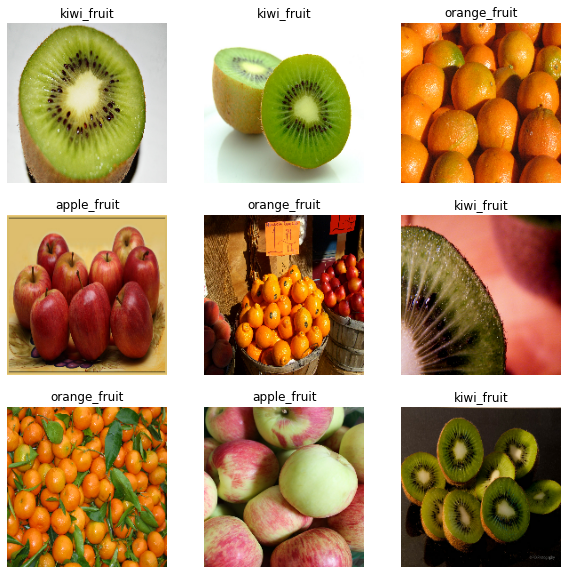

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


##Configure the dataset for performance


- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0014380362 0.9799355


## Create the model with overfitting
- The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. 
- There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). 



In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
- We use the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function.
- To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
38/38 [==============================] - 21s 341ms/step - loss: 0.7909 - accuracy: 0.6180 - val_loss: 0.4775 - val_accuracy: 0.8148
Epoch 2/10
38/38 [==============================] - 2s 44ms/step - loss: 0.4076 - accuracy: 0.8539 - val_loss: 0.5212 - val_accuracy: 0.8249
Epoch 3/10
38/38 [==============================] - 2s 43ms/step - loss: 0.3301 - accuracy: 0.8917 - val_loss: 0.5876 - val_accuracy: 0.7980
Epoch 4/10
38/38 [==============================] - 2s 42ms/step - loss: 0.3040 - accuracy: 0.8950 - val_loss: 0.4420 - val_accuracy: 0.8350
Epoch 5/10
38/38 [==============================] - 2s 43ms/step - loss: 0.2166 - accuracy: 0.9236 - val_loss: 0.3971 - val_accuracy: 0.8687
Epoch 6/10
38/38 [==============================] - 2s 42ms/step - loss: 0.1381 - accuracy: 0.9488 - val_loss: 0.5780 - val_accuracy: 0.8350
Epoch 7/10
38/38 [==============================] - 2s 43ms/step - loss: 0.1094 - accuracy: 0.9631 - val_loss: 0.5060 - val_accuracy: 0.8350
Epoch 8/10


### Visualize result

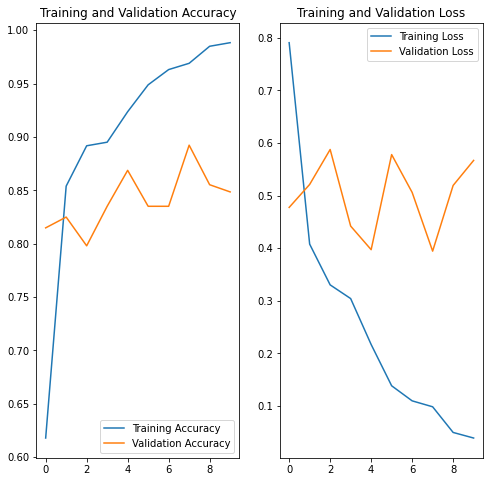

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 80% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. We'll use data augmentation and add Dropout to your model.

## Create trained Model

### Data Augmentation
Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

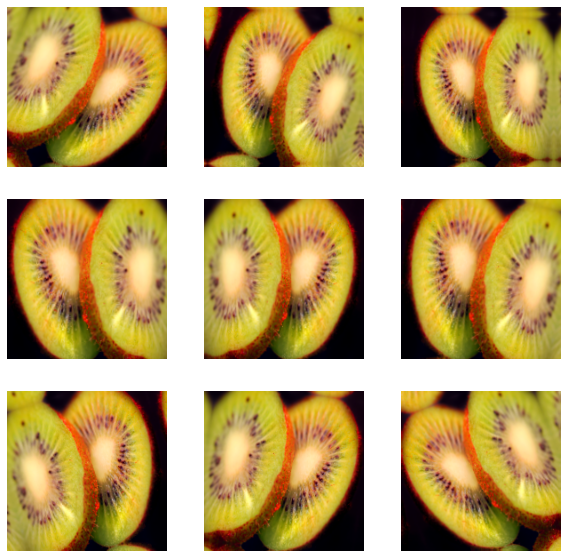

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
38/38 [==============================] - 3s 54ms/step - loss: 1.0237 - accuracy: 0.5600 - val_loss: 0.6269 - val_accuracy: 0.7003
Epoch 2/15
38/38 [==============================] - 2s 48ms/step - loss: 0.4976 - accuracy: 0.7993 - val_loss: 0.4318 - val_accuracy: 0.8620
Epoch 3/15
38/38 [==============================] - 2s 49ms/step - loss: 0.3882 - accuracy: 0.8657 - val_loss: 0.5056 - val_accuracy: 0.8249
Epoch 4/15
38/38 [==============================] - 2s 49ms/step - loss: 0.4040 - accuracy: 0.8497 - val_loss: 0.3922 - val_accuracy: 0.8552
Epoch 5/15
38/38 [==============================] - 2s 49ms/step - loss: 0.3455 - accuracy: 0.8715 - val_loss: 0.4094 - val_accuracy: 0.8519
Epoch 6/15
38/38 [==============================] - 2s 49ms/step - loss: 0.3284 - accuracy: 0.8766 - val_loss: 0.4334 - val_accuracy: 0.8350
Epoch 7/15
38/38 [==============================] - 2s 48ms/step - loss: 0.3213 - accuracy: 0.8808 - val_loss: 0.3783 - val_accuracy: 0.8653
Epoch 8/15
38

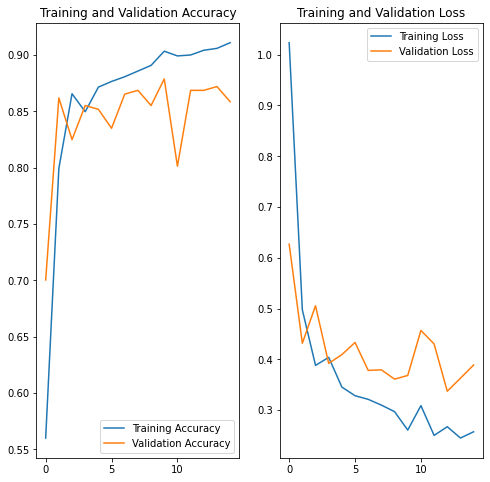

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test Trained Model

In [ ]:
import glob

folder = 'images'
n_samples = 10

for keywords in class_names:
  generate_images(keywords, n_samples)




0/10 https://live.staticflickr.com/3139/2780642603_920207d6cd_o.jpg
1/10 https://live.staticflickr.com/4078/4758324234_ede596d87f_o.jpg
2/10 https://live.staticflickr.com/2943/15340043005_82ea91f010_o.jpg
3/10 https://farm66.staticflickr.com/65535/51752990963_199a2e1b8c_b.jpg
4/10 https://live.staticflickr.com/7813/47082111862_47e8aab95a_o.jpg
5/10 https://farm66.staticflickr.com/65535/48459450566_5f64ee1f65_b.jpg
6/10 https://farm66.staticflickr.com/65535/51325926441_67c69d9614_b.jpg
7/10 https://farm8.staticflickr.com/7891/39662478523_c46324da86_b.jpg
8/10 https://live.staticflickr.com/65535/49398090427_da5dc6fd1b_o.jpg
9/10 https://farm66.staticflickr.com/65535/50841664367_0fe41fec19_b.jpg
Done. (104.5s)
All images saved to /content/images/apple_fruit/
0/10 https://live.staticflickr.com/65535/48570390581_d4f8d3639b_o.jpg
1/10 https://live.staticflickr.com/4166/33570197324_093b1bc713_o.jpg
2/10 https://live.staticflickr.com/4852/46537889152_652f9c75cd_o.jpg
3/10 https://live.staticfl

In [ ]:
%cd gdrive/My Drive/CodingMinds
!zip -r test_images.zip test_fruit_images/

[Errno 2] No such file or directory: 'gdrive/My Drive/CodingMinds'
/content
	zip warning: name not matched: test_fruit_images/

zip error: Nothing to do! (try: zip -r test_images.zip . -i test_fruit_images/)


kiwi_fruit


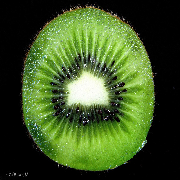

This image most likely belongs to kiwi_fruit with a 100.00 percent confidence. While the real value is kiwi_fruit


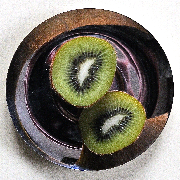

This image most likely belongs to kiwi_fruit with a 96.37 percent confidence. While the real value is kiwi_fruit


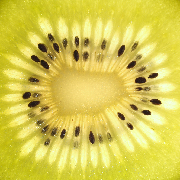

This image most likely belongs to kiwi_fruit with a 99.95 percent confidence. While the real value is kiwi_fruit


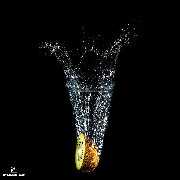

This image most likely belongs to kiwi_fruit with a 99.92 percent confidence. While the real value is kiwi_fruit


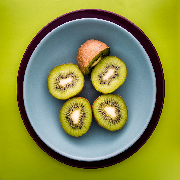

This image most likely belongs to kiwi_fruit with a 99.72 percent confidence. While the real value is kiwi_fruit


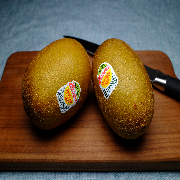

This image most likely belongs to kiwi_fruit with a 92.90 percent confidence. While the real value is kiwi_fruit


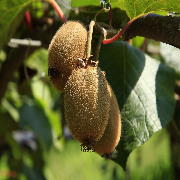

This image most likely belongs to kiwi_fruit with a 68.25 percent confidence. While the real value is kiwi_fruit


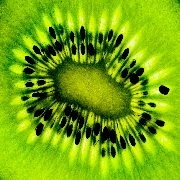

This image most likely belongs to kiwi_fruit with a 100.00 percent confidence. While the real value is kiwi_fruit


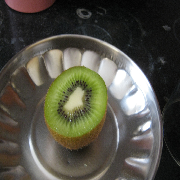

This image most likely belongs to kiwi_fruit with a 97.24 percent confidence. While the real value is kiwi_fruit


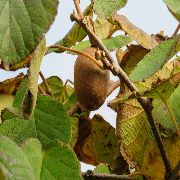

This image most likely belongs to kiwi_fruit with a 97.22 percent confidence. While the real value is kiwi_fruit
orange_fruit


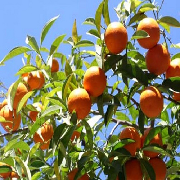

This image most likely belongs to kiwi_fruit with a 95.62 percent confidence. While the real value is orange_fruit


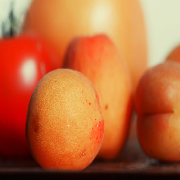

This image most likely belongs to apple_fruit with a 54.96 percent confidence. While the real value is orange_fruit


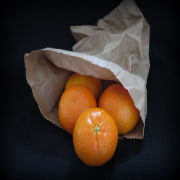

This image most likely belongs to orange_fruit with a 93.19 percent confidence. While the real value is orange_fruit


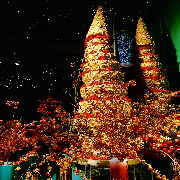

This image most likely belongs to kiwi_fruit with a 99.93 percent confidence. While the real value is orange_fruit


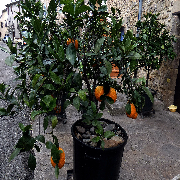

This image most likely belongs to orange_fruit with a 99.98 percent confidence. While the real value is orange_fruit


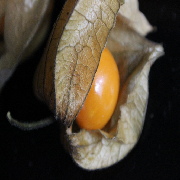

This image most likely belongs to orange_fruit with a 77.32 percent confidence. While the real value is orange_fruit


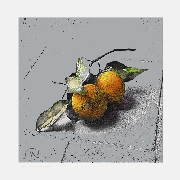

This image most likely belongs to kiwi_fruit with a 99.93 percent confidence. While the real value is orange_fruit


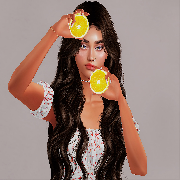

This image most likely belongs to kiwi_fruit with a 99.75 percent confidence. While the real value is orange_fruit


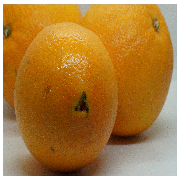

This image most likely belongs to orange_fruit with a 98.77 percent confidence. While the real value is orange_fruit


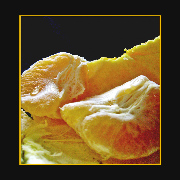

This image most likely belongs to orange_fruit with a 99.65 percent confidence. While the real value is orange_fruit
apple_fruit


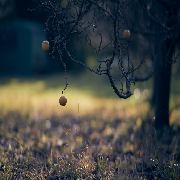

This image most likely belongs to kiwi_fruit with a 81.14 percent confidence. While the real value is apple_fruit


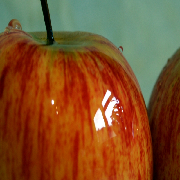

This image most likely belongs to orange_fruit with a 86.66 percent confidence. While the real value is apple_fruit


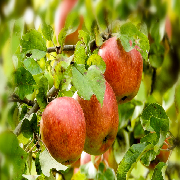

This image most likely belongs to orange_fruit with a 78.12 percent confidence. While the real value is apple_fruit


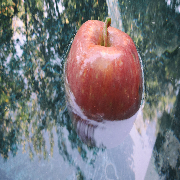

This image most likely belongs to apple_fruit with a 70.91 percent confidence. While the real value is apple_fruit


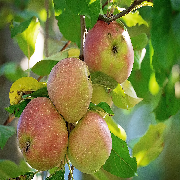

This image most likely belongs to kiwi_fruit with a 85.56 percent confidence. While the real value is apple_fruit


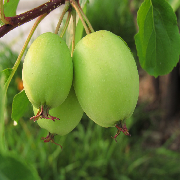

This image most likely belongs to kiwi_fruit with a 82.64 percent confidence. While the real value is apple_fruit


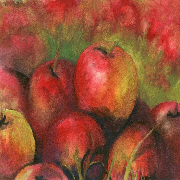

This image most likely belongs to apple_fruit with a 99.96 percent confidence. While the real value is apple_fruit


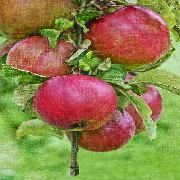

This image most likely belongs to apple_fruit with a 99.93 percent confidence. While the real value is apple_fruit


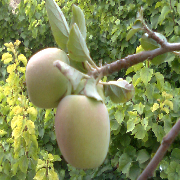

This image most likely belongs to orange_fruit with a 87.29 percent confidence. While the real value is apple_fruit


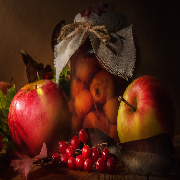

This image most likely belongs to apple_fruit with a 99.40 percent confidence. While the real value is apple_fruit


In [ ]:
for sub_dir in os.listdir('!unzip /content/images'): 
  print(sub_dir)
  for img_path in glob.glob(f"{folder}/{sub_dir}/*.jpg"):
    # print(img_path)
    try:
      img = image.load_img(img_path, target_size=(img_height,img_width))
      img_array = tf.keras.utils.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) # Create a batch

      predictions = model.predict(img_array)
      score = tf.nn.softmax(predictions[0])
      display(img)
      print(
          "This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)),  f"While the real value is {sub_dir}"
      ) 
    except Exception as e: 
      print(e)
      pass